# Word Level Language Model

In [ ]:
import string
import requests
import re
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

## Load the dataset
The dataset contains fairy tales which use simpler language with limited vocab so would be easier for model to learn. Only sentences that use top 5000 words are used. Punctuations are removed except periods. All sentences that contained quoted speeches are removed.

In [ ]:
!wget https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/4.4%20-%20Lab%20-%20Word-Level%20RNN/fairy_tales_cleaned_most_common_5000_words.txt -O dataset.txt

--2024-11-08 03:26:28--  https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/4.4%20-%20Lab%20-%20Word-Level%20RNN/fairy_tales_cleaned_most_common_5000_words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751228 (2.6M) [text/plain]
Saving to: ‘dataset.txt’

dataset.txt         100%[===================>]   2.62M  --.-KB/s    in 0.08s   

2024-11-08 03:26:29 (34.6 MB/s) - ‘dataset.txt’ saved [2751228/2751228]



In [ ]:
with open('dataset.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("Total Length in characters: ", len(text))

Total Length in characters:  2751174


## Word Level Tokenization

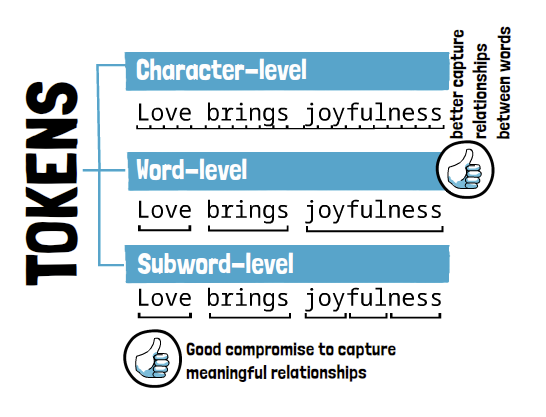

In [ ]:
def tokenize(doc):
  # Remove puntuation
  punctuation_to_remove = string.punctuation.replace(".", "")
  # Create translation table that removes specified punctuation except period
  table = str.maketrans('', '', punctuation_to_remove)
  tokens = doc.split()

  # Further split tokens by period and keep period as seperate tokens
  split_tokens = []
  for token in tokens:
    split_tokens.extend(token.replace('.', ' .').split())

  tokens = [w.translate(table) for w in split_tokens]
  tokens = [word for word in tokens if word.isalpha() or word == '.'] # Check if the word is all alphabet or period
  tokens = [word.lower() for word in tokens] # Convert all words/tokens to lowecase
  return tokens

In [ ]:
# tokenize
tokens = tokenize(text)
print(tokens[:100])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['the', 'happy', 'prince', '.', 'high', 'above', 'the', 'city', 'on', 'a', 'tall', 'column', 'stood', 'the', 'statue', 'of', 'the', 'happy', 'prince', '.', 'he', 'was', 'very', 'much', 'admired', 'indeed', '.', 'one', 'night', 'there', 'flew', 'over', 'the', 'city', 'a', 'little', 'swallow', '.', 'then', 'when', 'the', 'autumn', 'came', 'they', 'all', 'flew', 'away', '.', 'what', 'did', 'he', 'see', 'the', 'eyes', 'of', 'the', 'happy', 'prince', 'were', 'filled', 'with', 'tears', 'and', 'tears', 'were', 'running', 'down', 'his', 'golden', 'cheeks', '.', 'his', 'face', 'was', 'so', 'beautiful', 'in', 'the', 'moonlight', 'that', 'the', 'little', 'swallow', 'was', 'filled', 'with', 'pity', '.', 'round', 'the', 'garden', 'ran', 'a', 'very', 'lofty', 'wall', 'but', 'i', 'never', 'cared']
Total Tokens: 584955
Unique Tokens: 5371


## Create Vocabulary

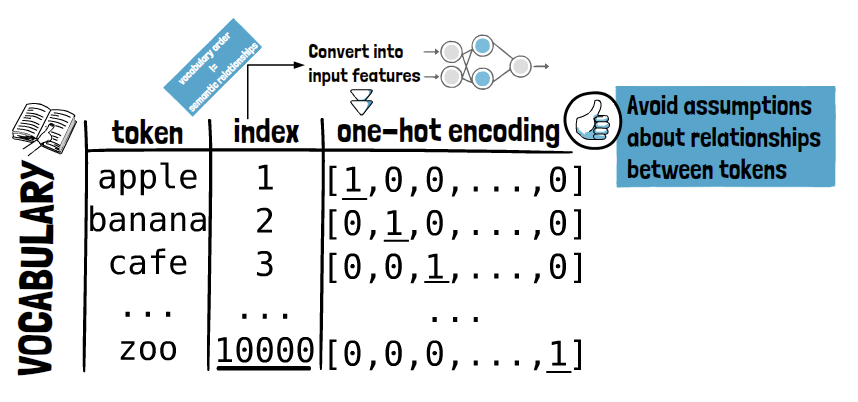

In [ ]:
vocabulary = sorted(list(set(tokens)))
len(vocabulary)

5371

In [ ]:
word2int = {words:i for i,words in enumerate(vocabulary)} # Create a dict of word to index
word_array = np.array(vocabulary) # NP array of tokens
text_encoded = np.array( # Extract the index for each token an create a np array
    [word2int[word] for word in tokens],
    dtype=np.int32
)
print('Text encoded shape: ', text_encoded.shape)
print('Tokens ==> ', tokens[:20], '\nEncoding ==> ', text_encoded[:20])
print(text_encoded[0:20], ' ==Reverse==> ', ' '.join(word_array[text_encoded[:20]]))

Text encoded shape:  (584955,)
Tokens ==>  ['the', 'happy', 'prince', '.', 'high', 'above', 'the', 'city', 'on', 'a', 'tall', 'column', 'stood', 'the', 'statue', 'of', 'the', 'happy', 'prince', '.'] 
Encoding ==>  [4735 2109 3621    0 2212    7 4735  813 3259    1 4681  882 4518 4735
 4482 3236 4735 2109 3621    0]
[4735 2109 3621    0 2212    7 4735  813 3259    1 4681  882 4518 4735
 4482 3236 4735 2109 3621    0]  ==Reverse==>  the happy prince . high above the city on a tall column stood the statue of the happy prince .


## Preparing pairs for self supervised training

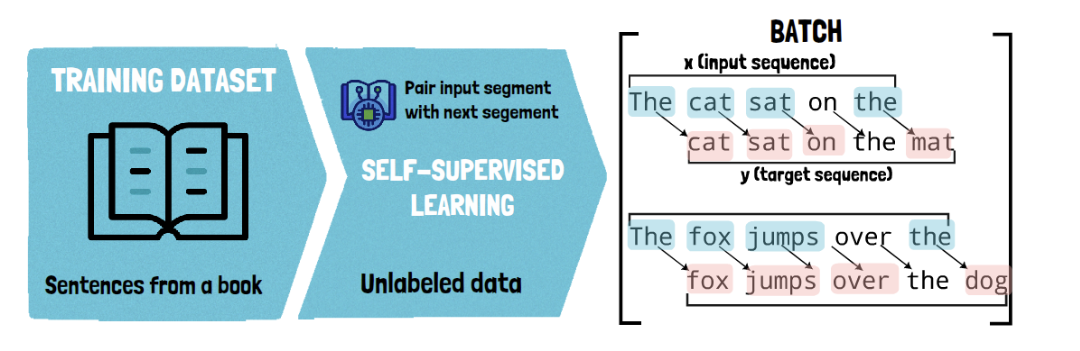

In [ ]:
seq_length = 50
chunk_size = seq_length + 1
text_chunks = [text_encoded[i:i+chunk_size] for i in range(len(text_encoded)-chunk_size+1)] # seq_length sized text chunks [[1->51],[2->52]...]
for seq in text_chunks[:1]:
  input_seq = seq[:seq_length] # Entire chunck except last word
  target_seq = seq[seq_length] # Last Word
  print(input_seq, '-->', target_seq)
  print(repr(' '.join(word_array[input_seq])), '-->', repr(''.join(word_array[target_seq])))

[4735 2109 3621    0 2212    7 4735  813 3259    1 4681  882 4518 4735
 4482 3236 4735 2109 3621    0 2149 5114 5050 3073   50 2371    0 3261
 3165 4743 1737 3297 4735  813    1 2733 4633    0 4742 5188 4735  289
  660 4751  116 1737  296    0 5179 1214] --> 2149
'the happy prince . high above the city on a tall column stood the statue of the happy prince . he was very much admired indeed . one night there flew over the city a little swallow . then when the autumn came they all flew away . what did' --> 'he'


In [ ]:
# Creating pytorch dataset out of our text chunks
from torch.utils.data import Dataset

class TextDataset(Dataset):
  def __init__(self, text_chunks):
    self.text_chunks = text_chunks

  def __len__(self):
    return len(self.text_chunks)

  def __getitem__(self, idx): # Each chunk is (inp: [1->49], targ: [2->50]), (inp: [2->50], targ: [3->51])
    input_seq = self.text_chunks[idx][:-1]
    target_seq = self.text_chunks[idx][1:]
    return input_seq.long(), target_seq.long()

seq_dataset = TextDataset(torch.tensor(text_chunks))

<ipython-input-9-3baf4fe704f3>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  seq_dataset = TextDataset(torch.tensor(text_chunks))


In [ ]:
# Lets look at the dataset
for i, (seq, target) in enumerate(seq_dataset): # Example below shows
  print('Input (x):', repr(' '.join(word_array[seq])))
  print('Target (y):', repr(' '.join(word_array[target])))
  print()
  if i==1:
    break

Input (x): 'the happy prince . high above the city on a tall column stood the statue of the happy prince . he was very much admired indeed . one night there flew over the city a little swallow . then when the autumn came they all flew away . what did'
Target (y): 'happy prince . high above the city on a tall column stood the statue of the happy prince . he was very much admired indeed . one night there flew over the city a little swallow . then when the autumn came they all flew away . what did he'

Input (x): 'happy prince . high above the city on a tall column stood the statue of the happy prince . he was very much admired indeed . one night there flew over the city a little swallow . then when the autumn came they all flew away . what did he'
Target (y): 'prince . high above the city on a tall column stood the statue of the happy prince . he was very much admired indeed . one night there flew over the city a little swallow . then when the autumn came they all flew away . what did he

In [ ]:
from torch.utils.data import DataLoader
seq_dataloader = DataLoader(seq_dataset, batch_size=64, shuffle=True, drop_last=True)

## Create Model

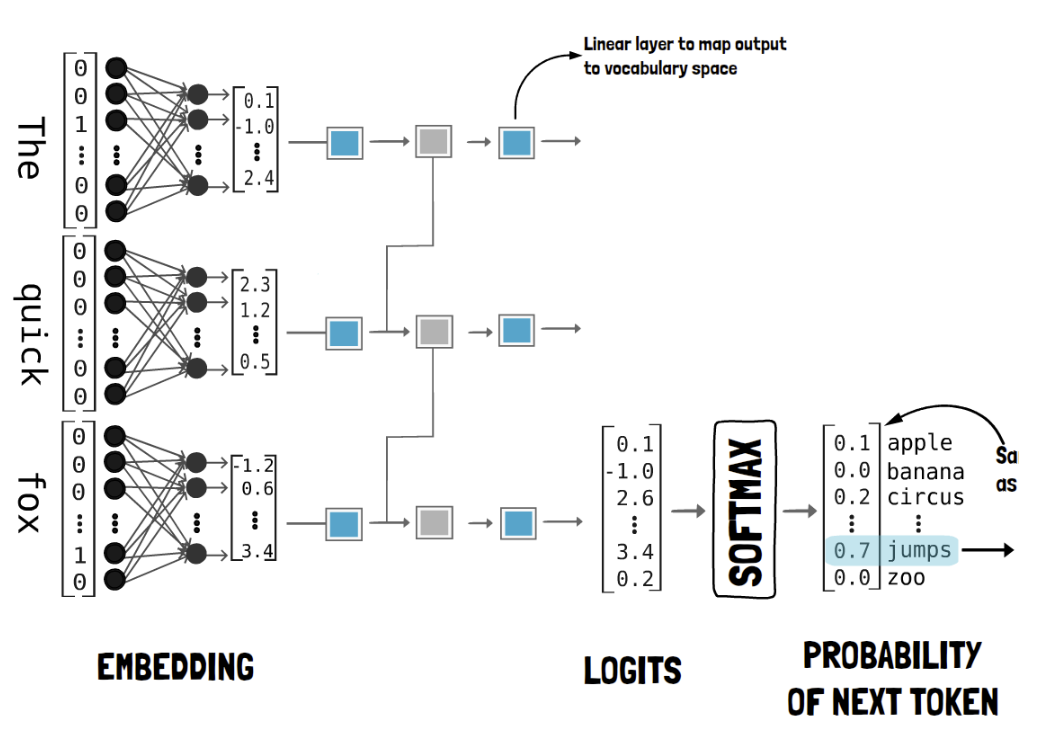

In [ ]:
# Set the device cpu/gpu
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.rnn_hidden_size = rnn_hidden_size
    self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
    self.fc = nn.Linear(rnn_hidden_size, vocab_size)

  def forward(self, x, hidden, cell):
    out = self.embedding(x).unsqueeze(1) # Unsqueeze to get batch dim  (seq_len, vocab) (vocab, embed) => (seq_len, embed) => (batch, seq_len, embed)
    out, (hidden, cell) = self.rnn(out, (hidden, cell)) # (batch,seq_len, embed) (embed, hidden) => (batch, seq_len, hidden)
    out = self.fc(out).reshape(out.shape[0], -1) # reshaping converts batch*vocabsize to vocabsize*batch (batch, seq_len, hidden) (hidden, vocab) => (batch, seq_len,vocab) => (batch, seq_len*vocab)
    return out, hidden, cell

  def init_hidden(self, batch_size):
    hidden = torch.zeros(1, batch_size, self.rnn_hidden_size) #Initialize hidden and cell initial state
    cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
    return hidden.to(DEVICE), cell.to(DEVICE)

vocab_size = len(word_array)
embed_dim = 256
rnn_hidden_size = 512
num_epochs = 15000
learning_rate = 0.005

model = RNN(vocab_size, embed_dim, rnn_hidden_size).to(DEVICE)
model

RNN(
  (embedding): Embedding(5371, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=5371, bias=True)
)

## Train the model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.to(DEVICE)
model.train()
for epoch in range(num_epochs):
  hidden, cell = model.init_hidden(batch_size=64)
  seq_batch, target_batch = next(iter(seq_dataloader))
  seq_batch = seq_batch.to(DEVICE)
  target_batch = target_batch.to(DEVICE)
  optimizer.zero_grad()
  loss = 0
  for w in range(seq_length): # Going over each timestep in a sequence
    pred, hidden, cell = model(seq_batch[:,w], hidden, cell) # We do teacher forcing here since we do not use predicted output but the training sample words in next word
    loss += loss_fn(pred, target_batch[:,w])
  loss.backward()
  optimizer.step()
  loss = loss.item()/seq_length
  if (epoch+1) % 500 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

Epoch [500/15000], Loss: 3.9595
Epoch [1000/15000], Loss: 3.3259
Epoch [1500/15000], Loss: 3.0155
Epoch [2000/15000], Loss: 2.7076
Epoch [2500/15000], Loss: 2.5552
Epoch [3000/15000], Loss: 2.4144
Epoch [3500/15000], Loss: 2.1414
Epoch [4000/15000], Loss: 2.2579
Epoch [4500/15000], Loss: 2.1799
Epoch [5000/15000], Loss: 2.0884
Epoch [5500/15000], Loss: 2.0908
Epoch [6000/15000], Loss: 2.0153
Epoch [6500/15000], Loss: 2.0519
Epoch [7000/15000], Loss: 1.9915
Epoch [7500/15000], Loss: 2.0961
Epoch [8000/15000], Loss: 2.0714
Epoch [8500/15000], Loss: 2.0523
Epoch [9000/15000], Loss: 2.0496
Epoch [9500/15000], Loss: 1.9806
Epoch [10000/15000], Loss: 2.1736
Epoch [10500/15000], Loss: 2.1752
Epoch [11000/15000], Loss: 2.1213
Epoch [11500/15000], Loss: 2.1185
Epoch [12000/15000], Loss: 2.1937
Epoch [12500/15000], Loss: 2.1187
Epoch [13000/15000], Loss: 2.1614
Epoch [13500/15000], Loss: 2.2361
Epoch [14000/15000], Loss: 2.1182
Epoch [14500/15000], Loss: 2.1107
Epoch [15000/15000], Loss: 2.2770


## Temperature and Top-P Sampling

We typically don't want to always pick the word with the highest probability as the next token, as our outputs would become very predictable and often repetitive. Instead, we want our model to be creative and generate diverse outputs.

Two common strategies combined together to control the model's "creativity" and predictability are:

- **Top-p Sampling**: here we sample from the top predictions whose combined probability does not exceed the value p.

- **Temperature**:  this directly impacts the probability distribution of the upcoming token. Think of it as tweaking the sharpness of this distribution.When the temperature is set to a value less than one, the softmax probability distribution becomes sharp. On the other hand, a higher temperature spreads out the probability distribution, making it flatter.

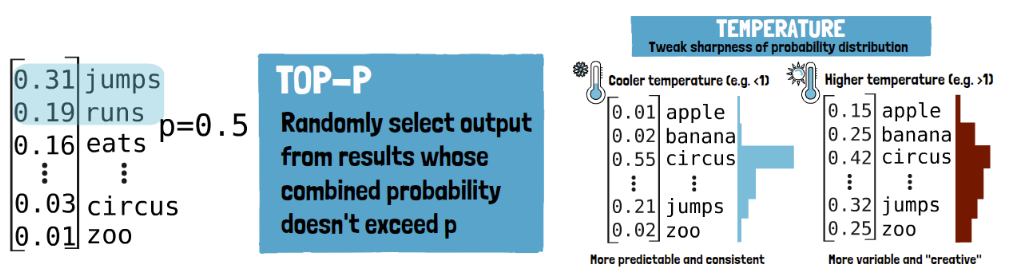

In [ ]:
def top_p_sampling(logits, temperature = 1.0, top_p=0.9):
  # Apply provided temperature
  scaled_logits = logits / temperature

  # Convert logits to probabilities using softmax
  probabilities = torch.softmax(scaled_logits, dim=-1)

  # Sort probabilities and compute cumulative sum
  sorted_indices = torch.argsort(probabilities, descending=True)
  sorted_probabilities = probabilities[sorted_indices]
  cumulative_probabilities = torch.cumsum(sorted_probabilities, dim=-1) # Gives list of cumulative sums [1,2,3] -> [1,3,6]

  # Apply top-p filtering
  indices_to_keep = cumulative_probabilities <= top_p
  truncated_probabilities = sorted_probabilities[indices_to_keep]

  # Rescale the probabilities
  truncated_probabilities = truncated_probabilities / torch.sum(truncated_probabilities)

  # Convert to numpy arrays for random choice
  truncated_probabilities = truncated_probabilities.cpu().numpy()
  sorted_indices = sorted_indices.cpu().numpy()
  indices_to_keep = indices_to_keep.cpu().numpy()

  # Sample from the truncated distribution
  if not indices_to_keep.any():
    # Handle the empty case - for example using regular sampling of the top k
    probabilities = torch.softmax(logits/temperature, dim=-1)
    next_word_index = torch.multinomial(probabilities, num_samples=1).item() # Pull next randomly based on the prob dist
  else:
    # Non empty case - sampling from kept indices
    next_word_index = np.random.choice(sorted_indices[indices_to_keep], p=truncated_probabilities)

  return torch.tensor(next_word_index).to(DEVICE)

## Generate Text

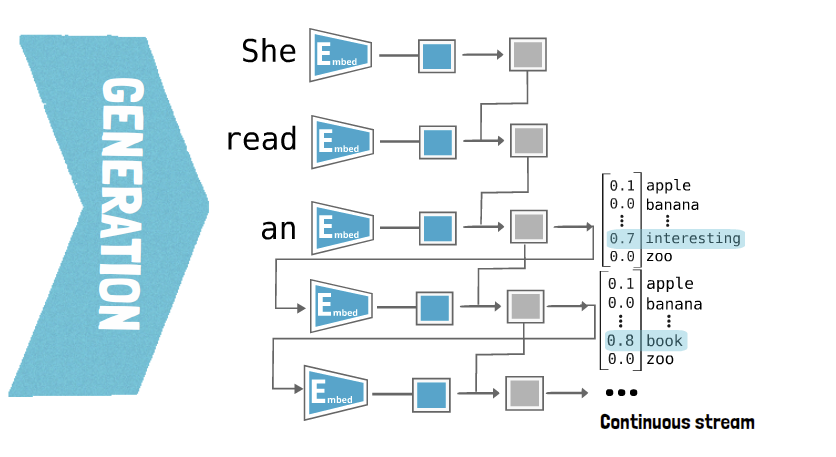

In [ ]:
def generate(model, seed_str, len_generated_text=50, temperature=1, top_p=0.95):
  seed_tokens = tokenize(seed_str)
  encoded_input = torch.tensor([word2int[token] for token in seed_tokens])
  encoded_input = torch.reshape(encoded_input, (1,-1)).to(DEVICE)
  generated_text = seed_str
  model.eval()
  with torch.inference_mode():
    hidden, cell = model.init_hidden(1) # Provinding the batch size
    hidden = hidden.to(DEVICE)
    cell = cell.to(DEVICE)
    for w in range(len(seed_tokens)-1):
      _, hidden, cell = model(encoded_input[:,w].view(1), hidden, cell)
    last_word = encoded_input[:, -1]
    for i in range(len_generated_text):
      logits, hidden, cell = model(last_word.view(1), hidden, cell)
      logits = torch.squeeze(logits, 0)
      last_word= top_p_sampling(logits, temperature, top_p)
      generated_text += " " + str(word_array[last_word])
  return generated_text.replace(" . ", ". ")

In [ ]:
model.to(DEVICE)
print(generate(model, seed_str="Once upon a time"))

Once upon a time but no smile. betty had a rather question to say but it was partly to find miss minchin and i do it because i can only have pity for you no more. as these thoughts did it somehow but where did they come around him right up .


## Word Embedding

An embedding layer simply projects the one-hot encoded tokens into a vector with fewer dimensions.

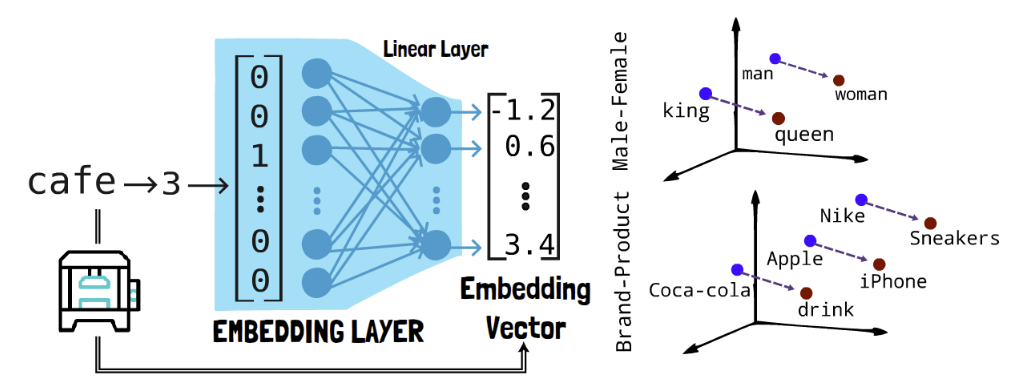

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def get_closest_words(model, word_idx, n=10):
  # Get the embedding for the specified word
  word_embedding = model.embedding(torch.tensor([word_idx])).detach().numpy()

  # Get all embeddings
  all_embeddings = model.embedding.weight.detach().numpy()

  # Calculate similarities (cosine similarities in this example)
  similarities = cosine_similarity(word_embedding, all_embeddings)

  # Find the indices of the most similar embeddings
  closest_idxs = np.argsort(similarities[0])[::-1][1:n+1] # Exclude the queried word

  return closest_idxs

In [ ]:
word_idx = word2int["she"]
model.to('cpu')
closest_idxs = get_closest_words(model, word_idx, n=10)
for idx in closest_idxs:
  print(word_array[idx])

he
kitty
fanny
marianne
cinderella
sarah
washington
mary
eliza
lily


## Pre-processing Dataset

Above dataset used after this preprocessing.

In [ ]:
%pip install nltk

In [ ]:
import re
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
import string

def process_fairy_tales(text):
  # Convert text to lowercase
  text = text.lower()

  # Tokenize the text into words and find the top 5000 words
  words = word_tokenize(text)
  top_words = [word for word, count in Counter(words).most_common(5000)]

  # Tokenize the text into sentences
  sentences = sent_tokenize(text)

  # Filter Sentences
  filtered_sentences = []
  for sentence in sentences:
    # Remove sentences with quoted dialogue
    if re.search(r'["“”]', sentence):
      continue

    # Check if all words in the sentence are in the top 5000 words
    sentence_words = word_tokenize(sentence)
    if all(word in top_words for word in sentence_words):
      # Remove all punctuations except periods
      sentence = re.sub(r'[^\w\s\.]', '', sentence)
      filtered_sentences.append(sentence)

    # Join the remaining sentences
    return ' '.join(filtered_sentences)

nltk.download('punkt')
processed_text = process_fairy_tales(text)
len(processed_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


17

In [ ]:
file_name = "fairy_tales_simple_dataset_most_common_5000_words.txt"

with open(file_name, 'w') as file:
    file.write(processed_text)